# Cluster Analysis

Here, we cluster the results of the LitAI model to see common groupings

In [1]:
# operate in project root directory

from os import chdir
import sys

# set path to allow module import
project_root = '/home/mike/litai'
if project_root not in sys.path:
    sys.path.append(project_root)

# operate in project root directory
chdir(project_root)

In [2]:
# get the top-scoring articles from the senescence table from this year

from litai import SearchEngine


# initialize engine
engine = SearchEngine()

# set number of articles to get and date cutoff
num_articles = 1000
min_date = '2022-04-01'

# pull articles
articles = engine.search(scores_table='senescence', limit=num_articles, min_date=min_date)

# check out articles
articles.head()

,PMID,Date,Title,Abstract,Keywords,Score
0,35554151,2022-05-01,Fisetin Supplementation Improves Age-Related V...,Fisetin supplementation may be a novel strateg...,,4.098535
1,35749057,2022-06-24,Mitochondrial SIRT3 Deficiency Results in Neur...,Aging is the major risk factor for Alzheimer's...,Amyloid plaques Electroencephalogram Epileptic...,4.030601
2,35384128,2022-04-05,Magnetic resonance elastography to study the e...,Aging had region-specific effects on cerebral ...,Alzheimer's disease J20 mice MRE brain parench...,3.874797
3,35460064,2022-04-23,Telomeres and Mitochondrial Metabolism: Implic...,Cellular senescence is an irreversible cell ar...,Aging Cellular senescence Mitochondrial metabo...,3.826630
4,35430158,2022-06-01,Cellular senescence in the aging brain: A prom...,Aging is inevitable. Along with reduced abilit...,Aging Alzheimer’s disease Cellular senescence ...,3.782537


In [3]:
# pull negative articles, to train tokenizer
neg_articles = engine.search(limit=3*num_articles, min_date=min_date)

# show head
neg_articles.head()

,PMID,Date,Title,Abstract,Keywords
0,35461946,2022-04-21,How does artificial intelligence affect green ...,As the driving force behind the new wave of te...,GEC index GML index GMM GTC index Productivity...
1,35441335,2022-04-19,Scaling with body mass and age in glycolytic e...,Animals produce ATP through oxidative phosphor...,Age Body mass Dogs Glycolysis
2,34529858,2022-05-01,Recent biopharmaceutical applications of capil...,Biopharmaceuticals (recombinant technology-bas...,Biopharmaceuticals Capillary electrophoresis C...
3,35714541,2022-06-09,Highly-efficient and sequential recovery of ra...,A novel sinter method using ZnO as the activat...,Al/Si speciation transformation Coupling Al-Si...
4,35627879,2022-05-23,The Health Cost of Organizational Citizenship ...,Previous research has mainly focused on the po...,citizenship fatigue health complaints health-p...


In [4]:
# Transform articles to feature space

from numpy import concatenate, ones, zeros
from pandas import concat
from vhash import VHash

from litai.model import TokenRegressor


# combine data for tokenizer
X = TokenRegressor._get_text(
    concat(
        (
            articles.drop(columns=['Score']),
            neg_articles,
        )
    )
)
y = concatenate(
    (
        ones(len(articles)),
        zeros(len(neg_articles)),
    )
)

# tokenize
vhash = VHash().fit(X, y)
tokenized = vhash.transform(
    TokenRegressor._get_text(
        articles.drop(columns=['Score'])
    )
)

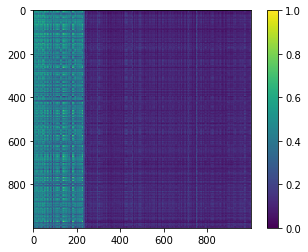

In [5]:
# show tokenized
# we expect this to look like a bunch of high-value columns (which are the latent space corresponding to the positive article projections) and a bunch of low-value columns (which correspond to the negative article projections)


from matplotlib import pyplot

pyplot.imshow(tokenized)
pyplot.colorbar()

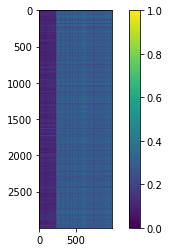

In [6]:
# let's also show the latent space for the negative articles, which should be the reverse of the above

tokenized_negative = vhash.transform(
    TokenRegressor._get_text(
        neg_articles
    )
)
pyplot.imshow(tokenized_negative)
pyplot.colorbar()

In [7]:
# now, let's cluster the positive articles
# we're going to use recursive hierarchical clustering, with a minimum and maximum group size

from typing import Any

from nptyping import NDArray
from numpy import argmax
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


class Clusterer:
    """Recursive Hierarchical Clustering

    Silhouette scores are used to determine the optimal number of clusters, and
    groups are recursively subdivided if they exceed a maximum group size
    
    Parameters
    ----------
    max_clusters: int, optional, default=10
        maximum number of clusters for any individual (non-hierarchical)
        clustering. The total number of output clusters can exceed this.
    max_size: float, optional, default=0.25
        maximum cluster size, as fraction of training data
    """
    def __init__(
        self,
        /,
        *,
        max_clusters: int = 10,
        max_size: float = 0.25,
    ):
        self._max_clusters = max_clusters
        self._max_size = max_size
    
    def fit_predict(
        self,
        /,
        X: NDArray[(Any, Any), float],
        y: Any = None,
    ) -> NDArray[(Any,), int]:
        """Fit model

        Parameters
        ----------
        X: 2D float NDArray
            training data
        y: Any
            ignored; supplied for sklearn-API consistency
        
        Returns
        -------
        1D int NDArray
            clusters for X
        """

        # get initial clusters
        clusters = self._cluster(X)

        # recursively subdivide
        cluster_num = 0
        while cluster_num <= clusters.max():

            # check if small enough group
            in_cluster = clusters == cluster_num
            if in_cluster.mean() <= self._max_size:
                cluster_num += 1
                continue

            # subdivide
            sub_clusters = self._cluster(X[in_cluster, :])

            # translate results
            clusters[clusters > cluster_num] += sub_clusters.max()
            clusters[in_cluster] += sub_clusters
        
        # return results
        return clusters

    def _cluster(
        self,
        /,
        X: NDArray[(Any, Any), float],
    ) -> NDArray[(Any,), int]:
        """Cluster data using kmeans + silhouette scoring

        Parameters
        ----------
        X: 2D float NDArray
            training data
        
        Returns
        -------
        1D int NDArray
            clusters for X
        """
        clusters = [
            KMeans(n_clusters=n).fit_predict(X)
            for n in range(2, self._max_clusters)
        ]
        scores = [
            silhouette_score(X, cluster)
            for cluster in clusters
        ]
        return clusters[argmax(scores)]

clusters = Clusterer().fit_predict(tokenized)

In [8]:
# show top keywords for each cluster
from collections import Counter

from numpy import argsort, array, concatenate


for cluster_num in range(clusters.max() + 1):
    
    # get articles in cluster
    in_cluster = clusters == cluster_num
    
    # get keywords and counts
    keywords = Counter(concatenate([
        article.split()
        for article in articles['Keywords'][in_cluster]
    ]))

    # get most common keywords
    order = argsort(list(keywords.values()))[::-1]
    common = array(list(keywords.keys()))[order][0: 10]
    print(f'Cluster {cluster_num}:', common)

Cluster 0: ['aging' 'Aging' 'senescence' 'stress' 'Mitochondrial' 'mitochondria'
 'cell' 'Oxidative' 'Mitochondria' 'function']
Cluster 1: ['aging' 'Aging' 'Health' 'dental' 'participation' 'Population' 'and'
 'care' 'dementia' 'zirconia']
Cluster 2: ['aging' 'Aging' 'Mitochondrial' 'mitochondria' 'mitochondrial'
 'Mitochondria' 'regulation' 'muscle' 'cells' 'UPR(mt)']
Cluster 3: ['aging' 'Aging' 'senescence' 'Epigenetics' 'disease' 'DNA' 'stress'
 'Biological' 'Cellular' 'length']
Cluster 4: ['aging' 'Aging' 'senescence' 'DNA' 'Facial' '-' 'stress' 'of' 'Bone'
 'obesity']
Cluster 5: ['aging' 'Aging' 'senescence' 'Senescence' 'quality' 'cellular'
 'properties' 'stress' 'cancer' 'skin']
Cluster 6: ['aging' 'age' 'Aging' 'epigenetic' 'of' 'skin' 'healthy' 'health' 'ratio'
 'facial']
Cluster 7: ['Aging' 'aging' 'diet' 'facial' 'of' 'fat' 'Social' 'antioxidant'
 'anti-aging' 'strength']
Cluster 8: ['senescence' 'Aging' 'aging' 'cells' 'Senescence' '4' 'Cellular'
 'receptor' 'cellular' 'str

So there's definitely a lot of overlap -- which is expected -- but there are definitely also distinct groups showing up.

Let's visualize these clusters

In [9]:
# get coordinates in dissimilarity space
from sklearn.manifold import MDS
from sklearn.neural_network import MLPRegressor


# get centers of clusters
centers = [
    tokenized[clusters == cluster_num, :].mean(axis=0)
    for cluster_num in range(clusters.max() + 1)
]

# project centers to 2D space
center_coords = MDS(dissimilarity='euclidean').fit_transform(centers)

# train ANN to project to 2D Space
mlp = MLPRegressor().fit(tokenized, center_coords[clusters])
coords = mlp.predict(tokenized)

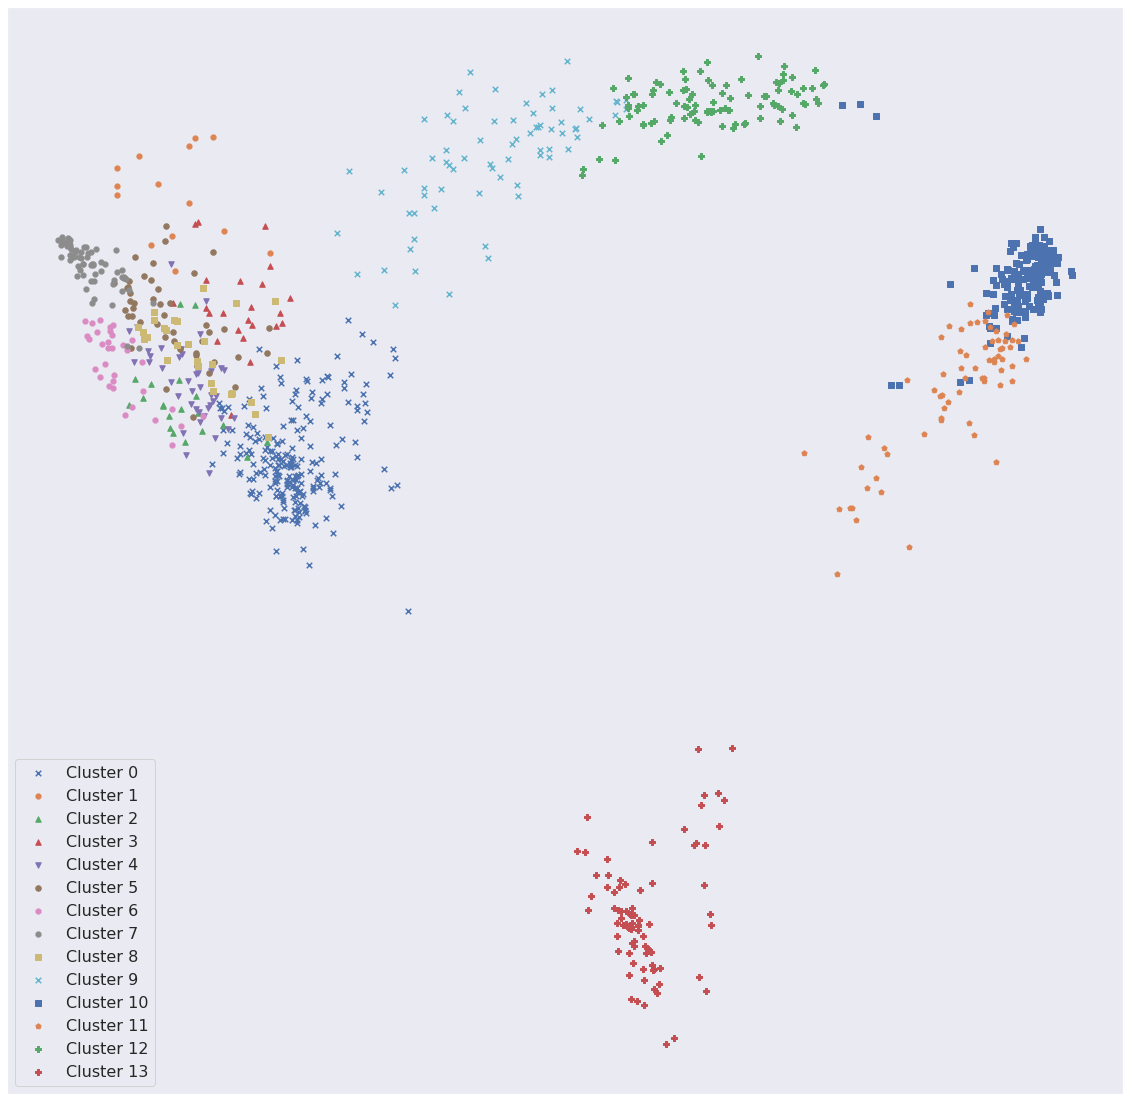

In [10]:
# plot clusters

from random import choice

from matplotlib import pyplot
import seaborn


# make pretty
seaborn.set_theme()

# create figure
fig, ax = pyplot.subplots(1, 1, figsize=(20, 20))

# plot clusters
for cluster_num in range(clusters.max() + 1):
    in_cluster = clusters == cluster_num
    x = coords[in_cluster, 0]
    y = coords[in_cluster, 1]
    ax.scatter(
        x,
        y,
        s=30,
        label=f'Cluster {cluster_num}',
        marker=choice(['o', 'v', '^', '8', 's', 'P', 'p', 'x']),
    )

# add legend
ax.legend(fontsize=16)

# hide axis labels (not meaningful)
ax.set_xticks([])
ax.set_yticks([])

# show figure
pyplot.show(fig)